In [1]:
import pandas as pd
import sys
import numpy as np
import random
from fuzzywuzzy import fuzz
import time
import psycopg2
import warnings
from scourgify import normalize_address_record
import networkx as nx
import pickle


import seaborn as sn
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,accuracy_score,confusion_matrix
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression , LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:

_user = ***
_dbname = ***
_host = ***
_secret_key = ***
_db_connection = psycopg2.connect(user = _user, dbname = _dbname, host = _host, password = _secret_key,port = ***)


In [4]:

def query_to_pandas(query,conn):
    '''
    Function to turn a hive query into a pandas data DataFrame
    '''
    with conn.cursor() as cur:
        cur.execute(query)
        colnames = [desc[0] for desc in cur.description]
        val=cur.fetchall()
        df=pd.DataFrame(data=val,columns=colnames)
        return(df)

In [5]:
features = '''
select * FROM datascience.becker_cpe_cust_with_bb_final_m1
'''

df = query_to_pandas(features, _db_connection
)

In [6]:
features = '''
select * FROM datascience.scrapped_bb_not_registered_final_m1
'''

sc = query_to_pandas(features, _db_connection
)

In [7]:
len(df),len(sc)

(2300, 175280)

In [9]:
df['dataset'] = 'df'
sc['dataset'] = 'sc'
df_new = pd.concat([df,sc],axis = 0)
df_new_id = df_new[['gale_id','append_id','sid','dataset']]
df_new_data = df_new.loc[:,['state_northeast',
 'state_midwest',
 'state_south',
 'state_west','age','issued_date',
 'income',
 'home_value',
 'net_worth',
 'marital_status_married',
 'marital_status_single',
 'female',
 'dwelling_type_a',
 'dwelling_type_m',
 'dwelling_type_c',
 'dwelling_type_s',
 'dwelling_type_p',
 'dwelling_type_unknown',
 'credit_range',
 'investments',
 'credit_cards',
 'num_of_adults',
 'num_in_household',
 'mail_buyer',
 'magazine',
 'len_of_residence',
 'investments_own_mutual_funds_cds',
 'investments_own_stocks_or_bonds',
 'home_improvement',
 'hobby_crafts',
 'hobby_cooking_gourmet',
 'gardening',
 'food',
 'entertainment_enth',
 'gen_in_household',
 'religion_catholic',
 'religion_protestant',
 'religion_others',
 'collectors',
 'consumer_electronics',
 'travel',
 'reading_news_finance',
 'sports',
 'has_made_cpe_with_becker']]
    

In [10]:
col_name =list(
['income',
 'home_value',
 'female',
 'marital_status_married',
 'marital_status_single',
 'dwelling_type_a',
 'dwelling_type_m',
 'dwelling_type_c',
 'dwelling_type_s',
 'dwelling_type_p',
 'dwelling_type_unknown',
 'credit_range',
 'investments',
 'credit_cards'
 ])

for i in col_name:
    df_new_data[i] = df_new_data[i].astype(int)

In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [12]:
df_new_data['issued_date'][df_new_data['issued_date'] == 0] = np.NaN 
mice_impute = IterativeImputer()
df_new_data[:] = mice_impute.fit_transform(df_new_data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
df_ft = pd.concat([df_new_id,df_new_data],axis = 1)
df_ft
dft = df_ft[df_ft['dataset'] == 'df']
sct = df_ft[df_ft['dataset'] == 'sc']

In [14]:
dft

,gale_id,append_id,sid,dataset,state_northeast,state_midwest,state_south,state_west,age,issued_date,...,gen_in_household,religion_catholic,religion_protestant,religion_others,collectors,consumer_electronics,travel,reading_news_finance,sports,has_made_cpe_with_becker
0,52861.0,866185139,OR12922,df,0.0,0.0,0.0,1.0,36.0,3541.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,50227.0,948973038,INCP11900334,df,0.0,1.0,0.0,0.0,42.0,7789.624224,...,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
2,52722.0,847758955,OK18732,df,0.0,0.0,1.0,0.0,40.0,19103.000000,...,3.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
3,3144950.0,900215999,MD6625,df,0.0,0.0,1.0,0.0,67.0,11586.598372,...,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
4,38945.0,992321902,NC25876,df,0.0,0.0,1.0,0.0,46.0,8211.000000,...,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,2164200.0,977067192,MO2010032500,df,0.0,1.0,0.0,0.0,46.0,3682.000000,...,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
2296,50711.0,1081653476,MI1101034436.0,df,0.0,1.0,0.0,0.0,31.0,7419.373226,...,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
2297,54309.0,819076661,VA40976.0,df,0.0,0.0,1.0,0.0,31.0,2663.000000,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2298,51165.0,808611029,MO2014043482,df,0.0,1.0,0.0,0.0,32.0,2125.000000,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [15]:
df_test = dft.sample(round(0.10*len(df)))
sc_test = sct.sample(round(0.10*len(sc)))

In [16]:
df1 = pd.merge(dft, df_test, how='left', indicator=True) \
           .query("_merge == 'left_only'") \
           .drop('_merge',1)
sc1 = pd.merge(sct, sc_test, how='left', indicator=True) \
           .query("_merge == 'left_only'") \
           .drop('_merge',1)

In [17]:
len(df_test),len(sc_test)

(230, 17528)

In [18]:
sc_train = sc1.sample(40000)
df_train = df1

In [19]:
df2 = pd.merge(df1, df_train, how='left', indicator=True) \
           .query("_merge == 'left_only'") \
           .drop('_merge',1)
sc2 = pd.merge(sc1, sc_train, how='left', indicator=True) \
           .query("_merge == 'left_only'") \
           .drop('_merge',1)

In [21]:
len(df_train),len(sc_train)

(2070, 40000)

In [23]:
ds = pd.concat([sc_train,df_train],axis=0).reset_index(drop = True)
len(sc2)

117752

In [24]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42070 entries, 0 to 42069
Data columns (total 48 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   gale_id                           42070 non-null  float64
 1   append_id                         42070 non-null  int64  
 2   sid                               42070 non-null  object 
 3   dataset                           42070 non-null  object 
 4   state_northeast                   42070 non-null  float64
 5   state_midwest                     42070 non-null  float64
 6   state_south                       42070 non-null  float64
 7   state_west                        42070 non-null  float64
 8   age                               42070 non-null  float64
 9   issued_date                       42070 non-null  float64
 10  income                            42070 non-null  float64
 11  home_value                        42070 non-null  float64
 12  net_

In [25]:
col_name =list(
['income',
 'home_value',
 'female',
 'marital_status_married',
 'marital_status_single',
 'dwelling_type_a',
 'dwelling_type_m',
 'dwelling_type_c',
 'dwelling_type_s',
 'dwelling_type_p',
 'dwelling_type_unknown',
 'credit_range',
 'investments',
 'credit_cards'
 ])

for i in col_name:
    ds[i] = ds[i].astype(int)

In [27]:
ds = ds[['gale_id',
 'append_id',
 'sid',
 'state_northeast',
 'state_midwest',
 'state_south',
 'state_west','age','issued_date',
 'income',
 'home_value',
 'net_worth',
 'marital_status_married',
 'marital_status_single',
 'female',
 'dwelling_type_a',
 'dwelling_type_m',
 'dwelling_type_c',
 'dwelling_type_s',
 'dwelling_type_p',
 'dwelling_type_unknown',
 'credit_range',
 'investments',
 'credit_cards',
 'num_of_adults',
 'num_in_household',
 'mail_buyer',
 'magazine',
 'len_of_residence',
 'investments_own_mutual_funds_cds',
 'investments_own_stocks_or_bonds',
 'home_improvement',
 'hobby_crafts',
 'hobby_cooking_gourmet',
 'gardening',
 'food',
 'entertainment_enth',
 'gen_in_household',
 'religion_catholic',
 'religion_protestant',
 'religion_others',
 'collectors',
 'consumer_electronics',
 'travel',
 'reading_news_finance',
 'sports',
 'has_made_cpe_with_becker']]

In [28]:
from sklearn.preprocessing import StandardScaler
features =['income','home_value','net_worth']
#for i in features:
 #   ds[i] = StandardScaler().fit_transform(ds[[i]])
ds.head()

,gale_id,append_id,sid,state_northeast,state_midwest,state_south,state_west,age,issued_date,income,...,gen_in_household,religion_catholic,religion_protestant,religion_others,collectors,consumer_electronics,travel,reading_news_finance,sports,has_made_cpe_with_becker
0,2111690.0,865476560,AL3705,0.0,0.0,1.0,0.0,56.0,12158.000000,125000,...,3.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,871486.0,1029554831,CA62437,0.0,0.0,0.0,1.0,54.0,8899.429796,125000,...,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
2,3473470.0,1104304903,NJ20CC00449300,1.0,0.0,0.0,0.0,80.0,20216.000000,125000,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,29244.0,876787981,CA90470,0.0,0.0,0.0,1.0,42.0,4258.357997,125000,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,1701200.0,1053130820,OH001t000000BcTpHAAV,0.0,1.0,0.0,0.0,76.0,18547.000000,25000,...,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [29]:
ds.head()

,gale_id,append_id,sid,state_northeast,state_midwest,state_south,state_west,age,issued_date,income,...,gen_in_household,religion_catholic,religion_protestant,religion_others,collectors,consumer_electronics,travel,reading_news_finance,sports,has_made_cpe_with_becker
0,2111690.0,865476560,AL3705,0.0,0.0,1.0,0.0,56.0,12158.000000,125000,...,3.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,871486.0,1029554831,CA62437,0.0,0.0,0.0,1.0,54.0,8899.429796,125000,...,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
2,3473470.0,1104304903,NJ20CC00449300,1.0,0.0,0.0,0.0,80.0,20216.000000,125000,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,29244.0,876787981,CA90470,0.0,0.0,0.0,1.0,42.0,4258.357997,125000,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,1701200.0,1053130820,OH001t000000BcTpHAAV,0.0,1.0,0.0,0.0,76.0,18547.000000,25000,...,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [30]:
df1_contact = ds[['gale_id','append_id','sid']]
df1_data = ds.loc[:,['state_northeast',
 'state_midwest',
 'state_south',
 'state_west','age','issued_date',
 'income',
 'home_value',
 'net_worth',
 'marital_status_married',
 'marital_status_single',
 'female',
 'dwelling_type_a',
 'dwelling_type_m',
 'dwelling_type_c',
 'dwelling_type_s',
 'dwelling_type_p',
 'dwelling_type_unknown',
 'credit_range',
 'investments',
 'credit_cards',
 'num_of_adults',
 'num_in_household',
 'mail_buyer',
 'magazine',
 'len_of_residence',
 'investments_own_mutual_funds_cds',
 'investments_own_stocks_or_bonds',
 'home_improvement',
 'hobby_crafts',
 'hobby_cooking_gourmet',
 'gardening',
 'food',
 'entertainment_enth',
 'gen_in_household',
 'religion_catholic',
 'religion_protestant',
 'religion_others',
 'collectors',
 'consumer_electronics',
 'travel',
 'reading_news_finance',
 'sports',
 'has_made_cpe_with_becker']]
    

In [31]:
#divide train and test (initially for building the model)
#X_train, X_test, y_train, y_test = train_test_split(df1_data.drop('has_made_cpe_with_becker',axis=1), 
 #          df1_data['has_made_cpe_with_becker'], test_size=0.30, 
  #          random_state=102)

In [32]:
#dividing positive and negative cases
#train = pd.concat([X_train,y_train],axis=1)    
X_train = df1_data.drop('has_made_cpe_with_becker',axis=1)
y_train = df1_data['has_made_cpe_with_becker']
train_pos = df1_data[df1_data['has_made_cpe_with_becker'] == 1]
train_neg = df1_data[df1_data['has_made_cpe_with_becker'] == 0]

In [264]:
from xgboost import XGBClassifier
models = []
for i in range(0,15):
    train_sample = pd.concat([train_pos.sample(1500),train_neg.sample(4500)],axis=0)
    train_X = train_sample.iloc[:,0:43]
    train_Y = train_sample.iloc[:,-1]
# fit model no training data
    gmb = XGBClassifier()
    gmb.fit(train_X, train_Y)
    models += [gmb]
    # save the model to disk
    pickle.dump(models[i],open('gmb_m1_'+str(i)+'.sav','wb'))


In [67]:
test = pd.concat([df_test,sc_test],axis=0).reset_index()
test

,index,gale_id,append_id,sid,dataset,state_northeast,state_midwest,state_south,state_west,age,...,gen_in_household,religion_catholic,religion_protestant,religion_others,collectors,consumer_electronics,travel,reading_news_finance,sports,has_made_cpe_with_becker
0,1752,48619.0,800981442,CA113899,df,0.0,0.0,0.0,1.0,56.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
1,1102,24826.0,896764345,CA117618,df,0.0,0.0,0.0,1.0,47.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1267,54012.0,977540885,VA16010,df,0.0,0.0,1.0,0.0,55.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
3,1126,35384.0,1024877060,IAO13159,df,0.0,1.0,0.0,0.0,31.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,2256,43421.0,935180229,OR13393,df,0.0,0.0,0.0,1.0,38.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17753,12820,3254850.0,1023113584,CA89689,sc,0.0,0.0,0.0,1.0,42.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
17754,134762,3012520.0,950225705,INCP10400409,sc,0.0,1.0,0.0,0.0,41.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
17755,117341,1676720.0,804747849,CA21004,sc,0.0,0.0,0.0,1.0,77.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
17756,9148,3023750.0,866455078,MI1101018260.0,sc,0.0,1.0,0.0,0.0,57.0,...,2.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0


In [68]:
test = pd.concat([df_test,sc_test],axis=0).reset_index()
test_1i = test.loc[:,['state_northeast',
 'state_midwest',
 'state_south',
 'state_west','age','issued_date',
 'income',
 'home_value',
 'net_worth',
 'marital_status_married',
 'marital_status_single',
 'female',
 'dwelling_type_a',
 'dwelling_type_m',
 'dwelling_type_c',
 'dwelling_type_s',
 'dwelling_type_p',
 'dwelling_type_unknown',
 'credit_range',
 'investments',
 'credit_cards',
 'num_of_adults',
 'num_in_household',
 'mail_buyer',
 'magazine',
 'len_of_residence',
 'investments_own_mutual_funds_cds',
 'investments_own_stocks_or_bonds',
 'home_improvement',
 'hobby_crafts',
 'hobby_cooking_gourmet',
 'gardening',
 'food',
 'entertainment_enth',
 'gen_in_household',
 'religion_catholic',
 'religion_protestant',
 'religion_others',
 'collectors',
 'consumer_electronics',
 'travel',
 'reading_news_finance',
 'sports',
 'has_made_cpe_with_becker']]

col_name =list(
['income',
 'home_value',
 'female',
 'marital_status_married',
 'marital_status_single',
 'dwelling_type_a',
 'dwelling_type_m',
 'dwelling_type_c',
 'dwelling_type_s',
 'dwelling_type_p',
 'dwelling_type_unknown',
 'credit_range',
 'investments',
 'credit_cards'
 ])

for i in col_name:
    test_1i[i] = test_1i[i].astype(int)
    
X_test = test_1i.drop('has_made_cpe_with_becker',axis=1)
y_test = test_1i['has_made_cpe_with_becker']

In [69]:
#for testing
models1 = []
pred1 = pd.DataFrame()
for i in range(0,15):
    loaded_model = pickle.load(open('gmb_m1_'+str(i)+'.sav', 'rb'))
    models1 += [loaded_model]
    y_pred = models1[i].predict_proba(X_test)[:,1]
    pred1 = pd.concat([pred1, pd.DataFrame(y_pred, columns=[i])], axis =1)

In [70]:
#averege of probab for test
pred1['avg'] = pred1.mean(axis=1)
pred1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,avg
0,0.640066,0.152799,0.631746,0.474371,0.313243,0.544856,0.181273,0.399757,0.238834,0.672063,0.775675,0.807134,0.695476,0.869420,0.843688,0.549360
1,0.997140,0.995486,0.988990,0.989661,0.991102,0.992669,0.995098,0.997157,0.994375,0.982453,0.998299,0.994758,0.975891,0.993621,0.990361,0.991804
2,0.179860,0.548833,0.437658,0.577175,0.828748,0.396263,0.157624,0.675140,0.444035,0.743650,0.114818,0.861179,0.091111,0.474270,0.448955,0.465288
3,0.948487,0.988959,0.973563,0.988176,0.919174,0.985378,0.993196,0.985935,0.955458,0.992332,0.994494,0.892250,0.981582,0.955346,0.984454,0.969252
4,0.905766,0.873030,0.936647,0.527374,0.750301,0.836743,0.880770,0.403381,0.760068,0.878554,0.231478,0.532656,0.933683,0.941950,0.968448,0.757390


In [72]:
y_predictions= [1 if i > 0.50 else 0 for i in pred1['avg']]

In [271]:

precision = precision_score(y_test,y_predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test,y_predictions )
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)


Precision: 0.051025
Recall: 0.465217


In [ ]:
##Shapley Charts

In [74]:
import shap
shap_values = shap.TreeExplainer(models1[0]).shap_values(X_test)


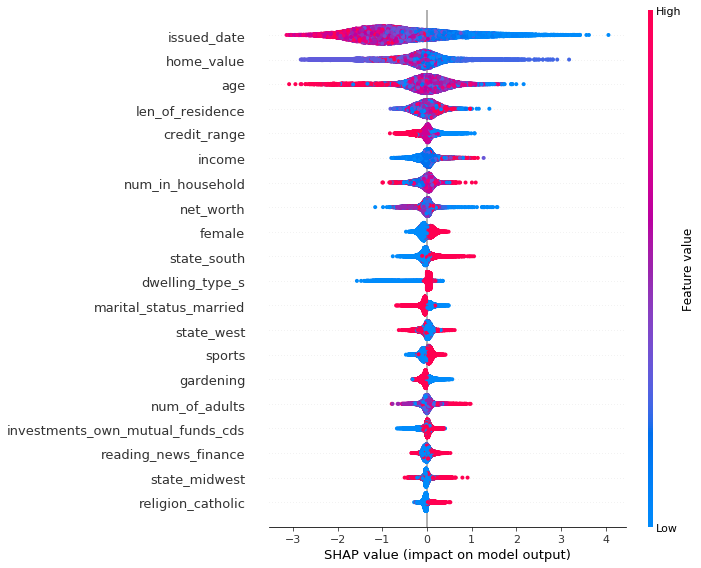

In [318]:

shap.summary_plot(shap_values, X_test)

invalid value encountered in true_divide
invalid value encountered in true_divide


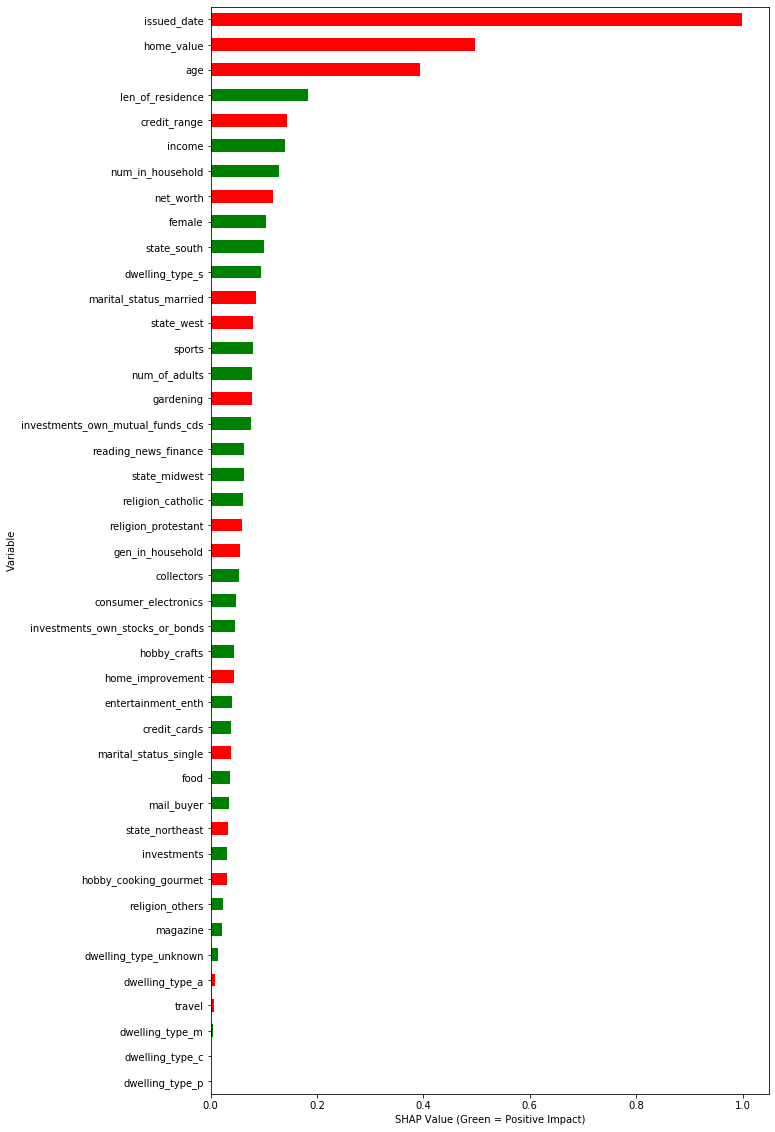

In [75]:

def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'green','red')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(10,20),legend=False)
    ax.set_xlabel("SHAP Value (Green = Positive Impact)")
    
ABS_SHAP(shap_values,X_test)

In [107]:
pred2 = pd.concat([y_test.reset_index(),pred1['avg']], axis =1)
pred2.sort_values('avg',inplace = True)
import numpy as np
my_frames = np.array_split(pred3, 10)

In [110]:
decile_df = pd.DataFrame(columns = ["total","bucket","is_cpe","is_not_cpe","hit_rate"])
for i in range(0,10):
    frame = my_frames[i]
    bucket = str(frame['avg'].min())+'-'+str(frame['avg'].max())
    total = len(frame)
    is_cpe = frame['has_made_cpe_with_becker'].sum()
    is_not_cpe = total - is_cpe
    hitrate = is_cpe / is_not_cpe
    bucket = str(round(frame['avg'].min(),4))+'-'+str(round(frame['avg'].max(),4))
    metrice = [total,bucket,is_cpe,is_not_cpe,hitrate]
    a_series = pd.Series(metrice, index = decile_df.columns)
    decile_df = decile_df.append(a_series, ignore_index=True)
decile_df 
decile_df.to_csv('decile_model3_m1_.csv')

In [112]:
decile_df

,total,bucket,is_cpe,is_not_cpe,hit_rate
0,1776,0.0004-0.0253,1.0,1775.0,0.000563
1,1776,0.0253-0.0597,3.0,1773.0,0.001692
2,1776,0.0597-0.0953,3.0,1773.0,0.001692
3,1776,0.0954-0.1327,6.0,1770.0,0.003390
4,1776,0.1327-0.1751,10.0,1766.0,0.005663
5,1776,0.1751-0.2216,15.0,1761.0,0.008518
6,1776,0.2216-0.2867,22.0,1754.0,0.012543
7,1776,0.2868-0.3783,33.0,1743.0,0.018933
8,1775,0.3784-0.5357,37.0,1738.0,0.021289
9,1775,0.5357-0.9965,100.0,1675.0,0.059701


In [ ]:
##Shapley Modelling Examples(Low Medium and High )

In [84]:
shap_df = pd.DataFrame(shap_values[:,:], columns = X_test.columns, index = X_test.index)
shap_df.round(2)

,state_northeast,state_midwest,state_south,state_west,age,issued_date,income,home_value,net_worth,marital_status_married,...,entertainment_enth,gen_in_household,religion_catholic,religion_protestant,religion_others,collectors,consumer_electronics,travel,reading_news_finance,sports
0,0.01,-0.01,0.05,0.05,0.55,-0.39,0.06,0.18,0.11,0.02,...,0.03,0.17,-0.04,-0.05,0.00,0.02,0.01,-0.00,0.23,0.00
1,-0.02,-0.01,0.02,0.05,0.52,-0.01,0.00,3.00,0.37,0.27,...,0.04,0.08,-0.07,-0.01,-0.01,-0.00,-0.01,0.01,0.00,-0.01
2,0.05,0.01,0.05,0.02,-0.23,-0.98,-0.32,0.67,-0.05,0.03,...,0.04,0.04,-0.02,-0.01,-0.01,0.19,0.04,-0.01,0.11,0.01
3,0.03,-0.07,-0.21,0.01,-0.00,0.52,-0.16,2.51,-0.16,0.43,...,-0.01,-0.08,0.00,-0.01,-0.01,0.05,-0.04,0.01,0.01,-0.03
4,0.02,0.04,0.03,0.23,0.37,2.01,0.07,-0.45,0.16,-0.12,...,0.21,0.09,-0.03,-0.07,-0.02,0.07,-0.04,0.06,0.10,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17753,-0.02,0.00,-0.05,-0.12,-0.26,0.64,0.26,-0.90,-0.04,-0.04,...,-0.06,0.00,-0.06,-0.11,0.03,-0.01,-0.21,-0.01,-0.02,0.07
17754,0.01,0.28,-0.04,0.13,-0.45,0.22,0.34,-0.45,0.05,0.15,...,0.03,-0.03,0.03,-0.01,-0.02,0.00,-0.07,-0.01,0.24,0.07
17755,0.03,-0.06,-0.48,-0.20,-1.38,-2.47,-0.12,-0.23,0.04,0.13,...,0.04,0.03,0.02,-0.17,-0.01,0.01,0.02,-0.00,-0.21,0.07
17756,0.03,-0.44,-0.12,0.02,-0.36,-1.45,0.34,-0.32,-0.34,-0.04,...,-0.00,0.01,0.06,-0.06,-0.02,-0.02,0.03,-0.00,0.08,0.08


In [95]:
shap_dec = pd.merge(shap_df, my_frames[6], left_index=True, right_index=True)
shap_dec.to_csv("model3_shp_low_performance.csv")

In [ ]:
## Predictions on the Validation set

In [31]:
df1_contact = sc2[['gale_id','append_id','sid']]
df1_data = sc2.loc[:,['state_northeast',
 'state_midwest',
 'state_south',
 'state_west',
 'income',
 'home_value',
 'net_worth',
 'marital_status_married',
 'marital_status_single',
 'female',
 'dwelling_type_a',
 'dwelling_type_m',
 'dwelling_type_c',
 'dwelling_type_s',
 'dwelling_type_p',
 'dwelling_type_unknown',
 'credit_range',
 'investments',
 'credit_cards',
 'num_of_adults',
 'num_in_household',
 'mail_buyer',
 'magazine',
 'len_of_residence',
 'investments_own_mutual_funds_cds',
 'investments_own_stocks_or_bonds',
 'home_improvement',
 'hobby_crafts',
 'hobby_cooking_gourmet',
 'gardening',
 'food',
 'entertainment_enth',
 'gen_in_household',
 'religion_catholic',
 'religion_protestant',
 'religion_others',
 'collectors',
 'consumer_electronics',
 'travel',
 'reading_news_finance',
 'sports',
 'has_made_cpe_with_becker']]
    

In [32]:
col_name =list(
['income',
 'home_value',
 'female',
 'marital_status_married',
 'marital_status_single',
 'dwelling_type_a',
 'dwelling_type_m',
 'dwelling_type_c',
 'dwelling_type_s',
 'dwelling_type_p',
 'dwelling_type_unknown',
 'credit_range',
 'investments',
 'credit_cards'
 ])

for i in col_name:
    df1_data[i] = df1_data[i].astype(int)

In [33]:
my_set = df1_data.drop('has_made_cpe_with_becker',axis=1)

In [34]:
loaded_model = pickle.load(open('gmb_S'+str(1)+'.sav', 'rb'))
pred1 = pd.DataFrame()
y_pred = loaded_model.predict_proba(my_set)[:,1]
pred1 = pd.concat([pred1, pd.DataFrame(y_pred, columns=[0])], axis =1)